Cosine Sim 


In [1]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms, models
import torch
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

csv_path = "D:/NU/GDG/Project/archive/medium_data.csv"
image_dir = "D:/NU/GDG/Project/archive/images"

df = pd.read_csv(csv_path)

df['image_path'] = df['id'].astype(str) + ".jpg"  
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(image_dir, x))


In [2]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet.eval()

def extract_image_features(path):
    if not os.path.exists(path):
        return None  
    try:
        image = Image.open(path).convert('RGB')
        image = image_transform(image).unsqueeze(0)
        with torch.no_grad():
            features = resnet(image).squeeze().numpy()
        return features
    except Exception as e:
        return None  



c:\Users\saifk\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\saifk\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
text_model = SentenceTransformer('all-MiniLM-L6-v2')

def get_text_embedding(row):
    text = str(row['title']) + " " + str(row['subtitle'])
    return text_model.encode(text)


In [4]:
image_embeddings = []
text_embeddings = []
valid_rows = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    image_feat = extract_image_features(row['image_path'])
    if image_feat is None:
        continue 

    text_feat = get_text_embedding(row)
    combined = np.concatenate([image_feat, text_feat])

    image_embeddings.append(combined)
    valid_rows.append(idx)

df = df.loc[valid_rows].reset_index(drop=True)
df['combined_embedding'] = image_embeddings


100%|██████████| 6508/6508 [02:53<00:00, 37.45it/s]


In [5]:
def recommend_articles_by_keyword(keyword, top_k=5):
    query_text = keyword
    query_embed = text_model.encode(query_text)

    query_vector = np.concatenate([np.zeros(2048), query_embed])

    similarities = df['combined_embedding'].apply(
        lambda emb: np.dot(emb, query_vector) / (np.linalg.norm(emb) * np.linalg.norm(query_vector))
    )

    top_indices = similarities.sort_values(ascending=False).head(top_k).index
    return df.loc[top_indices]


In [6]:
def plot_recommendations(keyword, top_k=5):
    top_articles = recommend_articles_by_keyword(keyword, top_k)
    
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(top_articles.iterrows()):
        img = Image.open(row['image_path']).convert('RGB')
        plt.subplot(1, top_k, i+1)
        plt.imshow(img)
        plt.title(row['title'][:30], fontsize=9)
        plt.axis('off')
    plt.suptitle(f"Top-{top_k} Articles for: \"{keyword}\"")
    plt.show()


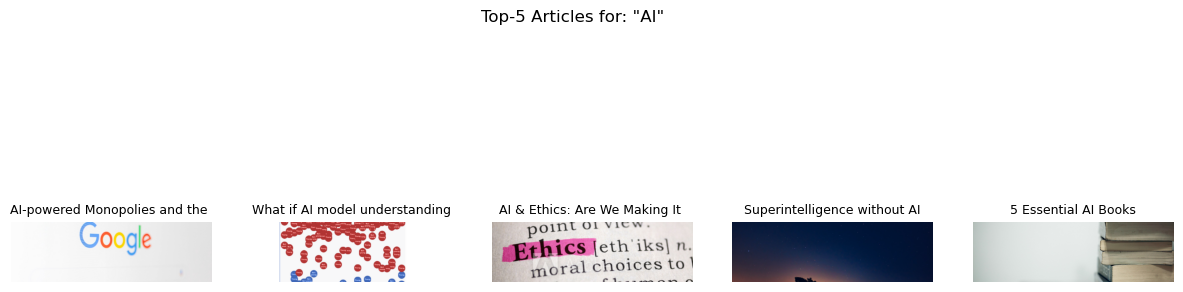

In [7]:
plot_recommendations("AI", top_k=5)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
embedding_matrix = np.stack(df['combined_embedding'].values)

cosine_sim_matrix = cosine_similarity(embedding_matrix)
def get_top_similar_articles(article_idx, top_k=5):
    similarities = cosine_sim_matrix[article_idx]
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]  
    return df.iloc[top_indices][['title', 'subtitle', 'image_path']], similarities[top_indices]
similar_articles, sim_scores = get_top_similar_articles(0, top_k=5)
for i, (row, score) in enumerate(zip(similar_articles.itertuples(), sim_scores)):
    print(f"Rank {i+1} | Score: {score:.3f}")
    print(f"Title: {row.title}")
    print(f"Subtitle: {row.subtitle}\n")




Rank 1 | Score: 0.801
Title: Six Recommendations for Aspiring Data Scientists
Subtitle: Building experience before landing a job

Rank 2 | Score: 0.790
Title: Can MXC Create an Additional Source of Revenue for NGOs?
Subtitle: nan

Rank 3 | Score: 0.776
Title: Data Minds: Evan Chow — Data Scientist at Snapchat
Subtitle: Data Minds is a series that profiles professionals…

Rank 4 | Score: 0.774
Title: Last Year I Spent $18,000 on Child Care
Subtitle: The ‘privilege’ of working motherhood comes at a high price —…

Rank 5 | Score: 0.770
Title: On the Road to Creativity: Are We There Yet?
Subtitle: My two cents on how to level up your creative game.



In [9]:
example_embedding = df['combined_embedding'].iloc[0]  


In [10]:
def generate_prompt_from_embedding(target_embedding, top_k=5):
    similarities = cosine_similarity([target_embedding], np.stack(df['combined_embedding'].values))[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]
    selected_texts = [
        f"Title: {df.iloc[i]['title']}\nSubtitle: {df.iloc[i]['subtitle']}" 
        for i in top_indices
    ]
    return "\n\n".join(selected_texts)


In [11]:
prompt = generate_prompt_from_embedding(example_embedding, top_k=5)


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "google/gemma-2b"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  
    device_map="auto"           
)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Now use it
prompt = "Write a new article inspired by the following:\n\nTitle: Future of AI\nSubtitle: How machines are shaping society"
output = generator(prompt, max_new_tokens=300)[0]['generated_text']

print(output)


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:  91%|######### | 4.48G/4.95G [00:00<?, ?B/s]

c:\Users\saifk\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saifk\.cache\huggingface\hub\models--google--gemma-2b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0


Write a new article inspired by the following:

Title: Future of AI
Subtitle: How machines are shaping society
By: John Doe, PhD in Machine Learning

One of the greatest advances in human history has been the creation of the machine. Machines have become so advanced that they are now capable of doing things that human beings cannot even imagine. The machine has become an important part of our society, and it has changed the way we live.

However, the machine is also a threat to human society. The machine can take over control of everything that we do, and it can take over our lives. It can make us lose our jobs, and it can make us lose our freedom. The machine is a threat to our future.

The machine is changing the way we live. It is changing our work, our leisure, and our relationships with each other. The machine is changing the way we think, and it is changing the way we feel. The machine is changing our world.

The future of the machine is bright. The machine is going to become sma

In [ ]:
from diffusers import StableDiffusionPipeline

generated_article =output

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")

image_prompt = generated_article[:150]  
generated_image = pipe(image_prompt).images[0]
generated_image.save("generated_image.png")
generated_image.show()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

c:\Users\saifk\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saifk\.cache\huggingface\hub\models--CompVis--stable-diffusion-v1-4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]